# VIDEO SURVEILLANCE ANOMALY DETECTION-H00390442

Thesis submission in fulfilment of the requirements for the degree of MSc. Artificial Intelligence. 


Video surveillance for crime prevention plays a vital role in public safety and security due to the high increase in crimes.  With the advent of new AI algorithms, new automatic detection methods have proved to be useful and these systems are trained to detect fires, raising alerts, identifying unattended baggage etc. in real-time. 

In this project, we compare and contrast different combination of models that uses Convolutional Neural Networks such as GoogLeNet, ResNet and Vision Transformers in a Transfer Learning approach using UCF Crime Dataset. The model will be evaluated based on measures such as accuracy and AUC curve.

The diagram below gives the steps involved to achieve the goal of the project. 

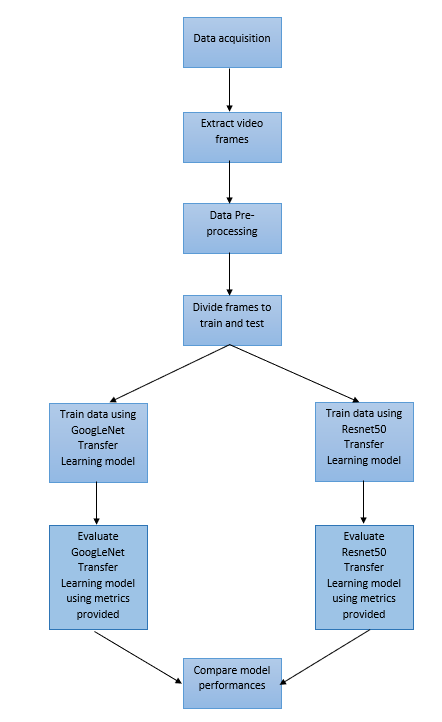

### The following cell is run for Vision Transformers and had to be placed before import commands to avoid error. 

In [51]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shutil
import math
import cv2
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

## Step 1: Data Acquisition

The dataset is downloaded from https://www.dropbox.com/sh/75v5ehq4cdg5g5g/AABvnJSwZI7zXb8_myBA0CLHa?dl=0 given in   https://www.crcv.ucf.edu/projects/real-world/ which consists of 13 folders of anomaly videos and one folder of normal videos. The dataset which consists of zip folders was downloaded and extracted.  

As we are focussing specifically on spatial features, we need to extract the frames from the videos.

## Step 2: Extract Video Frames


Following the documentation of opencv given in https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html, we extract the frames. 

In [ ]:
#The dataset was saved in an external harddisk due to the large size. Path to dataset in the system is given below 
root_dir=r"E:\DATASETS\UCF Crime\UCF Crime"

count = 0
videoFile = mainPath
cap = cv2.VideoCapture(root_dir)   # capturing the video from the given path
frameRate = cap.get(10) #frame rate
x=1
for dir in os.listdir(root_dir):
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        # Capture frame-by-frame
        ret, frame = cap.read()
        if (ret != True):
            print("Can't receive frame (stream end?). Exiting ...")
            break
        if (frameId % math.floor(frameRate) == 0):
            filename ="frame%d.png" % count;
            count+=1
            cv2.imwrite(filename, frame)
# When everything done, release the capture
cap.release()


Count the number of images extracted for each of the anomalies. 


In [4]:
Categories={}
for dir in os.listdir(root_dir):
    Categories[dir]=len(os.listdir(os.path.join(root_dir,dir)))

Categories

{'Abuse': 19076,
 'Arrest': 26397,
 'Arson': 24421,
 'Assault': 10360,
 'Burglary': 39504,
 'Explosion': 18753,
 'Fighting': 24684,
 'NormalVideos': 413920,
 'Robbery': 41493,
 'Shooting': 7140,
 'Shoplifting': 24835,
 'Stealing': 44802,
 'Vandalism': 13626,
 'RoadAccidents': 23486}

## Step 3: Splitting images to 80% train and 20% test data

In [6]:
#Creating Training folder

if not os.path.exists("./train"):
    os.mkdir("./train")
    
    for dir in os.listdir(root_dir):
        os.makedirs("./train/"+dir)
        for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)),size=(math.floor(80/100*Categories[dir])-5), replace=False):
            O=os.path.join(root_dir,dir,img)
            D=os.path.join("./train",dir)
            shutil.copy(O,D)
            os.remove(O)
            
else:
    print("Train Folder exists")

Train Folder exists


In [8]:
#Creating Test folder

if not os.path.exists("./test"):
    os.mkdir("./test")
    
    for dir in os.listdir(root_dir):
        os.makedirs("./test/"+dir)
        for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)),size=(math.floor(20/100*Categories[dir])-5), replace=False):
            O=os.path.join(root_dir,dir,img)
            D=os.path.join("./test",dir)
            shutil.copy(O,D)
            os.remove(O)
            
else:
    print("Test Folder exists")

Test Folder exists


In [3]:
train_dir = r"E:\DATASETS\UCF Crime\Train"
test_dir = r"E:\DATASETS\UCF Crime\Test"

## Step 4: Data Pre-processing using data generator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [4]:
#Data Preprocessing using data generator
train_datagen=image.ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1./255, horizontal_flip=True)
test_Datagen=image.ImageDataGenerator(rescale=1./255)

In [5]:
#Flow from directory: Loading data in terms of batches

train_data=train_datagen.flow_from_directory(directory=train_dir,target_size=(256,256), batch_size=64,color_mode = "rgb",class_mode='categorical')
test_data=test_Datagen.flow_from_directory(directory=test_dir,target_size=(256,256), batch_size=64,color_mode = "rgb",class_mode='categorical')

Found 732497 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


## Step 5: ResNet50 Model

Following the Keras documentation available from the following sites

https://keras.io/api/applications/resnet/#resnet50-function

https://keras.io/guides/transfer_learning/, 

we build our model by transfering the weights of ImageNet dataset. 

In [5]:
Resnet_model=Sequential()
pretrained_model=tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(256,256,3),classes=14)
for layer in pretrained_model.layers:
    layer.trainable=False
Resnet_model.add(pretrained_model)
Resnet_model.add(Flatten())
Resnet_model.add(Dense(14,activation='softmax'))

In [6]:
Resnet_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
Resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 14)                1835022   
Total params: 25,422,734
Trainable params: 1,835,022
Non-trainable params: 23,587,712
_________________________________________________________________


Having early stopping and model check point. 

In [7]:
# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')
# model check point
mc = ModelCheckpoint(filepath="resnet_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')
# puting call back in a list 
call_back = [es, mc]

### Experimentation of ResNet Model

The model was trained only on one epoch and later on five epochs. 

In [11]:
hist=Resnet_model.fit(x=train_data,validation_data=test_data, epochs=1, callbacks=call_back)

11446/11446 [==============================] - ETA: 0s - loss: 2.2121 - accuracy: 0.6738 - auc: 0.9081
Epoch 00001: val_accuracy improved from -inf to 0.43614, saving model to resnet_model.h5
11446/11446 [==============================] - 115791s 10s/step - loss: 2.2121 - accuracy: 0.6738 - auc: 0.9081 - val_loss: 3.5313 - val_accuracy: 0.4361 - val_auc: 0.8068


In [8]:
hist=Resnet_model.fit(x=train_data,validation_data=test_data, epochs=5, callbacks=call_back)

Epoch 1/5
11446/11446 [==============================] - ETA: 0s - loss: 2.2041 - accuracy: 0.6742 - auc: 0.9084
Epoch 00001: val_accuracy improved from -inf to 0.35243, saving model to resnet_model.h5
11446/11446 [==============================] - 123075s 11s/step - loss: 2.2041 - accuracy: 0.6742 - auc: 0.9084 - val_loss: 6.6845 - val_accuracy: 0.3524 - val_auc: 0.7507
Epoch 2/5
11446/11446 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.7511 - auc: 0.9356
Epoch 00002: val_accuracy did not improve from 0.35243
11446/11446 [==============================] - 121217s 11s/step - loss: 1.6085 - accuracy: 0.7511 - auc: 0.9356 - val_loss: 5.5417 - val_accuracy: 0.3222 - val_auc: 0.7341
Epoch 3/5
11446/11446 [==============================] - ETA: 0s - loss: 1.4199 - accuracy: 0.7808 - auc: 0.9440
Epoch 00003: val_accuracy did not improve from 0.35243
11446/11446 [==============================] - 123020s 11s/step - loss: 1.4199 - accuracy: 0.7808 - auc: 0.9440 - val_

### Loading the best fit model

In [9]:
from keras.models import load_model
model=load_model("resnet_model.h5")

### ResNet Model Accuracy

In [10]:
acc=model.evaluate_generator(generator=test_data,steps=len(test_data),verbose=1)[1]
print(f"The accuracy of Resnet50 model is ={acc*100}%")

Instructions for updating:
Please use Model.evaluate, which supports generators.
1740/1740 [==============================] - 14646s 8s/step - loss: 5.4911 - accuracy: 0.3928 - auc: 0.7735
The accuracy of Resnet50 model is =39.27749991416931%


In [11]:
h=hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

### ResNet model plot against training and validation accuracy

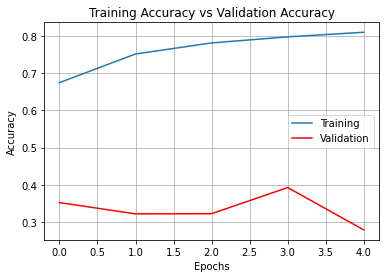

In [12]:
plt.plot(h['accuracy'],label='Training')
plt.plot(h['val_accuracy'],c='red',label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

## Step 6: GoogLeNet Model

Following the keras documentation available from https://keras.io/api/applications/inceptionv3/, we built our GoogLeNet model. 

In [16]:
Inceptionv3_model=Sequential()
pretrained_model_2=tf.keras.applications.InceptionV3(include_top=False,weights="imagenet",input_shape=(256,256,3))
for layer in pretrained_model_2.layers:
    layer.trainable=False
Inceptionv3_model.add(pretrained_model_2)
Inceptionv3_model.add(Flatten())
Inceptionv3_model.add(Dense(14,activation='softmax'))

In [17]:
Inceptionv3_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
Inceptionv3_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1032206   
Total params: 22,834,990
Trainable params: 1,032,206
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
# model check point
mc = ModelCheckpoint(filepath="googlenet_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')
# puting call back in a list 
call_back = [es, mc]

### Experimentation of GoogLeNet Model

The model was trained only on one epoch and later on five epochs.

In [23]:
hist_2=Inceptionv3_model.fit(x=train_data,validation_data=test_data, epochs=1, callbacks=call_back)

11446/11446 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.9653 - auc: 0.9846
Epoch 00001: val_accuracy improved from -inf to 0.52341, saving model to googlenet_model.h5
11446/11446 [==============================] - 93973s 8s/step - loss: 0.9252 - accuracy: 0.9653 - auc: 0.9846 - val_loss: 48.2088 - val_accuracy: 0.5234 - val_auc: 0.7513


In [32]:
hist_2=Inceptionv3_model.fit(x=train_data,validation_data=test_data, epochs=5, callbacks=call_back)

Epoch 1/5
11446/11446 [==============================] - ETA: 0s - loss: 0.8061 - accuracy: 0.9740 - auc: 0.9882
Epoch 00001: val_accuracy did not improve from 0.52341
11446/11446 [==============================] - 93695s 8s/step - loss: 0.8061 - accuracy: 0.9740 - auc: 0.9882 - val_loss: 53.7490 - val_accuracy: 0.4344 - val_auc: 0.7056
Epoch 2/5
11446/11446 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.9780 - auc: 0.9898
Epoch 00002: val_accuracy did not improve from 0.52341
11446/11446 [==============================] - 94182s 8s/step - loss: 0.7486 - accuracy: 0.9780 - auc: 0.9898 - val_loss: 68.2289 - val_accuracy: 0.3945 - val_auc: 0.6823
Epoch 3/5
11446/11446 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.9807 - auc: 0.9910
Epoch 00003: val_accuracy did not improve from 0.52341
11446/11446 [==============================] - 94423s 8s/step - loss: 0.6933 - accuracy: 0.9807 - auc: 0.9910 - val_loss: 65.5159 - val_accuracy: 0.5026 -

### Loading the best fit model

In [33]:
from keras.models import load_model
model_2=load_model("googlenet_model.h5")

### GoogLeNet Model Accuracy

In [34]:
acc=model_2.evaluate_generator(generator=test_data,steps=len(test_data),verbose=1)[1]
print(f"The accuracy of GoogLeNet model is ={acc*100}%")

1740/1740 [==============================] - 8965s 5s/step - loss: 48.2087 - accuracy: 0.5234 - auc_2: 0.7513
The accuracy of GoogLeNet model is =52.34125256538391%


In [35]:
h2=hist_2.history
h2.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

### GoogLeNet model plot against training and validation accuracy

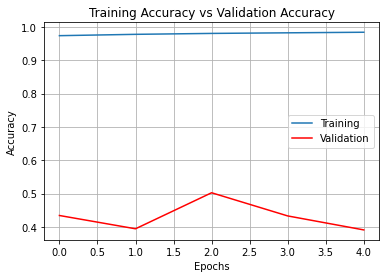

In [36]:
plt.plot(h2['accuracy'],label='Training')
plt.plot(h2['val_accuracy'],c='red',label='Validation')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

## Step 7: Vision Transformer

The following documentation of the model was followed from 

https://huggingface.co/docs/transformers/model_doc/vit#transformers.TFViTForImageClassification

https://huggingface.co/docs/transformers/training

### Installling necessary libraries

In [20]:
pip install git+https://github.com/huggingface/transformers.git

^C
Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install -q transformers

In [13]:
!pip install pytorch-transformers

  Using cached pytorch_transformers-1.2.0-py3-none-any.whl (176 kB)
  Using cached sacremoses-0.0.53.tar.gz (880 kB)
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=c415ea492044a4d13783c6f7dea922ef83fe8ca93961a234556d2b60e0cdf89d
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\12\1c\3d\46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses


In [18]:
pip install datasets

In [16]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


### Importing libraries related to Vision Transformers. 

In [7]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from huggingface_hub import notebook_login
#Created an account on hugging face and the notebook.login code is to access and can be done by copying the access code available from hugging face
from transformers import TFViTForImageClassification
from datasets import load_dataset
from transformers import AutoTokenizer
import tensorflow as tf
from keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping
from datetime import datetime
from transformers import TrainingArguments

In [23]:
#The following code cell was executed before the import statements to avoid error and can be seen as the first cell in this notebook. 
#install Git-LFS to upload your model checkpoints. For large data
'''
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store
'''

UsageError: Line magic function `%%capture` not found.


In [22]:
#Sign up in hugging face and copy token
notebook_login()

Login successful
Your token has been saved to C:\Users\User/.huggingface/token


### Importing data into Hugging Face hub and datasets

In [3]:
ds = load_dataset("imagefolder", data_dir=r"E:\DATASETS\UCF Crime\UCF Crime")
ds = ds['train']

Resolving data files:   0%|          | 0/472116 [00:00<?, ?it/s]

Using custom data configuration default-87092f773d6ae028
Reusing dataset imagefolder (C:\Users\User\.cache\huggingface\datasets\imagefolder\default-87092f773d6ae028\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/1 [00:00<?, ?it/s]

## Step 3: Splitting images to 80% train and 20% test data

In [4]:
data = ds.train_test_split(test_size=0.20)

In [5]:
print(f"Dataset Structure:\n{ds}",)
print(f"Dataset Labels: {', '.join(data['train'].features['label'].names)}")

Dataset Structure:
Dataset({
    features: ['image', 'label'],
    num_rows: 472116
})
Dataset Labels: Abuse, Arrest, Arson, Assault, Burglary, Explosion, Fighting, NormalVideos, RoadAccidents, Robbery, Shooting, Shoplifting, Stealing, Vandalism


#### create an id2label dictionary to decode them back to strings and see what they are. The inverse label2id will be useful too, when we load the model later.

In [6]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

## Step 4: Data Pre-processing

https://github.com/google-research/vision_transformer/blob/main/vit_jax/input_pipeline.py

The path shows that images are to be rescaled or resizedto the resolution (224,224). The model was pretrained on ImageNet-21k  dataset which consists of 14 million images and more than 21000 classes. Thefeature extractor takes the images and convert them to numbers to feed into the model.

In [8]:
model_3_path='google/vit-base-patch16-224-in21k'
feature_extractor_3 = ViTFeatureExtractor.from_pretrained(model_3_path)
model_3 = TFViTForImageClassification.from_pretrained(model_3_path)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torchvision.transforms usefor the image transformations/data augmentation https://pytorch.org/vision/stable/transforms.html#transforms-on-torch-tensor-only

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor_3.image_mean, std=feature_extractor_3.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor_3.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor_3.size),
            CenterCrop(feature_extractor_3.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [10]:
train_ds = data['train']
val_ds = data['test']

In [11]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

## Step 5: Vision Transformer (ViT) ModelTraining

In [61]:
model_3_path='google/vit-base-patch16-224'
model_3 = ViTForImageClassification.from_pretrained(
    model_3_path, 
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},ignore_mismatched_sizes=True
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json from cache at C:\Users\User/.cache\huggingface\transformers\6b03b61d64598274e01717c40e8909f9e70531219a281e8163bd5b3af5c92d1a.c41e6c561c79e9b15e74a5cc284a31cba59cb1a9e209933c1a04a46ba2e20e44
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Abuse",
    "1": "Arrest",
    "10": "Shooting",
    "11": "Shoplifting",
    "12": "Stealing",
    "13": "Vandalism",
    "2": "Arson",
    "3": "Assault",
    "4": "Burglary",
    "5": "Explosion",
    "6": "Fighting",
    "7": "NormalVideos",
    "8": "RoadAccidents",
    "9": "Robbery"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Abuse": "0",


In [55]:
model_3_path='google/vit-base-patch16-224'
model_3 = TFViTForImageClassification.from_pretrained(
    model_3_path, 
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},ignore_mismatched_sizes=True
)

loading configuration file https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json from cache at C:\Users\User/.cache\huggingface\transformers\6b03b61d64598274e01717c40e8909f9e70531219a281e8163bd5b3af5c92d1a.c41e6c561c79e9b15e74a5cc284a31cba59cb1a9e209933c1a04a46ba2e20e44
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Abuse",
    "1": "Arrest",
    "10": "Shooting",
    "11": "Shoplifting",
    "12": "Stealing",
    "13": "Vandalism",
    "2": "Arson",
    "3": "Assault",
    "4": "Burglary",
    "5": "Explosion",
    "6": "Fighting",
    "7": "NormalVideos",
    "8": "RoadAccidents",
    "9": "Robbery"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Abuse": "0",


In [56]:
optimizer_selection = "Adam"
learning_rate = 0.01 
num_of_epochs = 5
early_stopper_epochs_patience = 3 
freeze_vit_layer = True 
reset_model = True 
load_weights_by_name = "" 
og_weights = model_3.get_weights()
if reset_model:
    print("Reseting model to original weights")
    tf.keras.backend.clear_session()
    model_3.set_weights(og_weights)

if load_weights_by_name:
    print(f"Loading weights {load_weights_by_name}")
    model_3.load_weights(f"/content/model_weights/{load_weights_by_name}")

for layer in model_3.layers:
    if layer.name == "vit":
        if freeze_vit_layer:
            print("Freezing VIT layer")
            layer.trainable=False
        else:
            print("Fine-tuning the whole model")
            layer.trainable=True

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_3.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.AUC()],
              )

print(model_3.summary())
          

Reseting model to original weights
Freezing VIT layer
Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  10766     
                                                                 
Total params: 85,809,422
Trainable params: 10,766
Non-trainable params: 85,798,656
_________________________________________________________________
None


### Training the model

In [69]:
training_args = TrainingArguments(
    'UCF_Crime',
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=1,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

PyTorch: setting up devices


In [58]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [64]:
from datasets import load_metric

metric = load_metric("accuracy")

In [59]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

###  TrainingArguments, which is a class that contains all the attributes to customize the training. 

In [70]:
trainer = Trainer(
    model_3,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor_3,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

C:\Users\User\Heriot Watt\F21MP\UCF_Crime is already a clone of https://huggingface.co/csr2000/UCF_Crime. Make sure you pull the latest changes with `repo.git_pull()`.


#### The model could only be trained for 100 steps and one epoch. Kernal was purposely interrupted and  The model evaluation was not conducted due to time constraints and is mentioned in the thesis as well.

In [71]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 377692
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 11803


Step,Training Loss,Validation Loss,Accuracy
100,1.102800,0.831629,0.753389


***** Running Evaluation *****
  Num examples = 94424
  Batch size = 8
Saving model checkpoint to UCF_Crime\checkpoint-100
Configuration saved in UCF_Crime\checkpoint-100\config.json
Model weights saved in UCF_Crime\checkpoint-100\pytorch_model.bin
Feature extractor saved in UCF_Crime\checkpoint-100\preprocessor_config.json


KeyboardInterrupt: 

###  evaluate the model 

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)